In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

2024-12-03 15:59:12.492845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
hourly = pd.read_pickle('/Users/sele/Desktop/AUS FALL 24/repositories/Data-Mining-Project/Dataset/hourly.pkl')  # Read from pickle
fixed = pd.read_pickle('/Users/sele/Desktop/AUS FALL 24/repositories/Data-Mining-Project/Dataset/fixed.pkl')

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Extract input features
X_embeddings_hourly = np.stack(hourly['row_embedding'].values)  # Convert list of embeddings to a numpy array
# Add numerical features (drop target and embedding columns)
numerical_hourly = hourly.drop(columns=['Hourly_Rate', 'row_embedding'], axis=1)
# Combine embeddings and numerical features
X_hourly = np.hstack((X_embeddings_hourly, numerical_hourly.values))
# Extract the target variable
y_hourly =hourly['Hourly_Rate'].values


# Extract input features
X_embeddings_fixed = np.stack(fixed['row_embedding'].values)  # Convert list of embeddings to a numpy array

# Add numerical features (drop target and embedding columns)
numerical_fixed = fixed.drop(columns=['Job_Cost', 'row_embedding'], axis=1)

# Combine embeddings and numerical features
X_fixed = np.hstack((X_embeddings_fixed, numerical_fixed.values))

# Extract the target variable
y_fixed =fixed['Job_Cost'].values


In [4]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hourly, y_hourly, test_size=0.2, random_state=42)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fixed, y_fixed, test_size=0.2, random_state=42)


## Nueral Net for Hourly

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Model definition
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Best Parameters: {'model__learning_rate': 0.005, 'epochs': 100, 'batch_size': 64}

model1 = Sequential([
    Input(shape=(X_train_h.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model1.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])



# Define early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Early stopping
history = model1.fit(
    X_train_h, y_train_h,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 539.7359 - mae: 17.3850 - val_loss: 359.4516 - val_mae: 14.1194
Epoch 2/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 390.5622 - mae: 14.6121 - val_loss: 360.8473 - val_mae: 14.7989
Epoch 3/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 393.5026 - mae: 14.7450 - val_loss: 381.0792 - val_mae: 13.9653
Epoch 4/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 393.1919 - mae: 14.6464 - val_loss: 352.1787 - val_mae: 14.3359
Epoch 5/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 397.0248 - mae: 14.7818 - val_loss: 349.4510 - val_mae: 14.0184
Epoch 6/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 384.2902 - mae: 14.5379 - val_loss: 357.0344 - val_mae: 14.6221
Epoch 7/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 383.7835 - mae: 14.4290 - val_loss: 350.5471 - val_mae: 14.1004
Epoch 8/150
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 374.5260 - mae: 14.2750 - val_loss: 351.2335 - val_mae: 14.2350


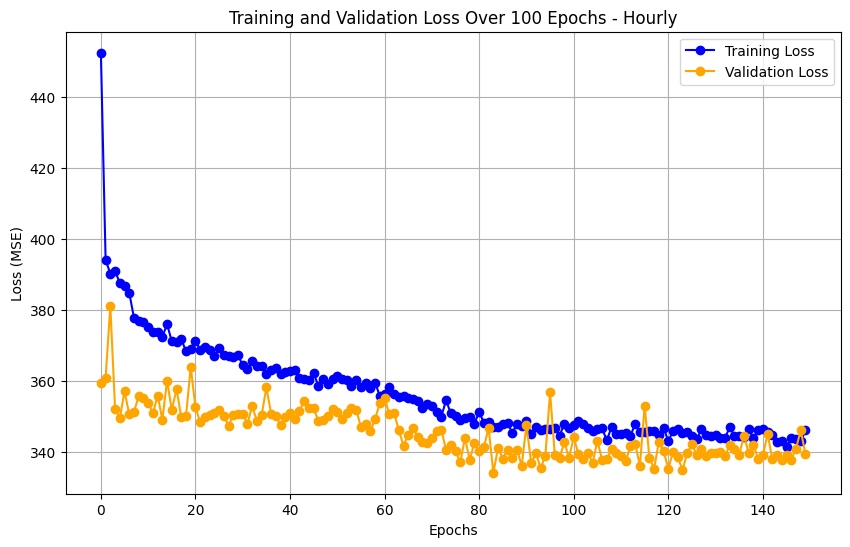

In [25]:
import matplotlib.pyplot as plt

# Assuming the `history` object is returned from the model.fit() function
# Example:
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss Over 100 Epochs - Hourly')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on X_test
y_pred = model1.predict(X_test_h).flatten()

# Calculate metrics
mse = mean_squared_error(y_test_h, y_pred)
mae = mean_absolute_error(y_test_h, y_pred)
r2 = r2_score(y_test_h, y_pred)  # R-squared (only for regression)
rmse = np.sqrt(mse)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 327.37
Mean Absolute Error (MAE): 13.71
R-squared (R²): 0.10
Root Mean Squared Error (RMSE): 18.09


## Randomized Search for Hourly Neural Netowork

In [19]:
# Define the neural network creation function
def create_model(learning_rate=0.01, neurons_layer1=128, neurons_layer2=64, neurons_layer3=32, dropout_rate=0.2, l2_reg=0.01):
    model = Sequential([
        Input(shape=(X_train_h.shape[1],)),  # Input layer
        Dense(neurons_layer1, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(neurons_layer3, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Define parameter grid for randomized search
param_grid = {
    "model__learning_rate": [0.005, 0.01, 0.05],        # Learning rates                # Neurons in third hidden layer                  # L2 regularization strength
    "batch_size": [32, 64],                           # Batch sizes
    "epochs": [50, 100]                               # Number of epochs
}
# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train_h, y_train_h)

# Get best parameters and results
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Negative RMSE):", best_score)




Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV] END batch_size=32, epochs=50, model__learning_rate=0.01; total time= 2.4min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.005; total time= 2.4min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.05; total time= 2.4min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.01; total time= 2.4min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.005; total time= 2.5min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.01; total time= 2.5min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.005; total time= 2.5min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.05; total time= 2.5min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.05; total time= 2.6min
[CV] END batch_size=32, epochs=100, model__learning_rate=0.005; total time= 4.8min
[CV] END batch_size=32, epochs=100, model__learning_rate=0.005; total time= 4.9min
[CV] END batch_size=32, epochs=100, model__learning_rate=0.005; total time= 5.0min
[CV] END batch_size

## Neural Net for Fixed

In [21]:
from tensorflow.keras.regularizers import l2
model2 = Sequential([
    Input(shape=(X_train_f.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

#Best Parameters: {'model__learning_rate': 0.005, 'epochs': 50, 'batch_size': 64}

# Define early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Early stopping
history2 = model2.fit(
    X_train_f, y_train_f,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3253250.5000 - mae: 721.6285 - val_loss: 3348613.2500 - val_mae: 866.1682
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2838215.2500 - mae: 810.2449 - val_loss: 3180477.2500 - val_mae: 824.2402
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2532412.0000 - mae: 775.9637 - val_loss: 2987505.7500 - val_mae: 844.3669
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2763091.0000 - mae: 806.4878 - val_loss: 2882340.7500 - val_mae: 780.1350
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2339833.2500 - mae: 728.3143 - val_loss: 2754476.5000 - val_mae: 743.8502
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2347820.0000 - mae: 708.1943 - val_loss: 2725601.7500 - val_mae: 680.3840
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2256909.0000 - mae: 690.2545 - val_loss: 2667717.0000 - val_mae: 668.7491
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23

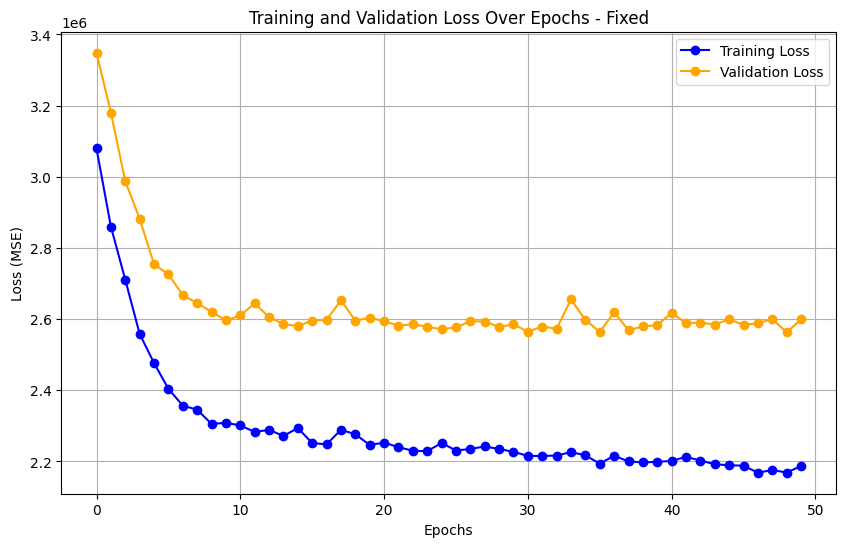

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss Over Epochs - Fixed')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on X_test
y_pred = model2.predict(X_test_f).flatten()

# Calculate metrics
mse = mean_squared_error(y_test_f, y_pred)
mae = mean_absolute_error(y_test_f, y_pred)
r2 = r2_score(y_test_f, y_pred)  # R-squared (only for regression)
rmse = np.sqrt(mse)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error (MSE): 2487968.12
Mean Absolute Error (MAE): 727.81
R-squared (R²): 0.18
Root Mean Squared Error (RMSE): 1577.33


## Randomized Search for Fixed Nueral Network Model

In [27]:
# Define the neural network creation function
def create_model(learning_rate=0.01, neurons_layer1=128, neurons_layer2=64, neurons_layer3=32, dropout_rate=0.2, l2_reg=0.01):
    model = Sequential([
        Input(shape=(X_train_f.shape[1],)),  # Input layer
        Dense(neurons_layer1, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(neurons_layer3, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Define parameter grid for randomized search
param_grid = {
    "model__learning_rate": [0.005, 0.01, 0.05],        # Learning rates                # Neurons in third hidden layer                  # L2 regularization strength
    "batch_size": [32, 64],                           # Batch sizes
    "epochs": [50, 100]                               # Number of epochs
}
# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train_f, y_train_f)

# Get best parameters and results
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Negative RMSE):", best_score)




Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV] END batch_size=32, epochs=50, model__learning_rate=0.005; total time= 2.1min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.01; total time= 2.1min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.01; total time= 2.2min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.005; total time= 2.2min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.01; total time= 2.3min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.05; total time= 2.3min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.005; total time= 2.3min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.05; total time= 2.4min
[CV] END batch_size=32, epochs=50, model__learning_rate=0.05; total time= 2.1min
[CV] END batch_size=32, epochs=100, model__learning_rate=0.005; total time= 3.8min
[CV] END batch_size=32, epochs=100, model__learning_rate=0.005; total time= 3.8min
[CV] END batch_size=32, epochs=100, model__learning_rate=0.005; total time= 3.9min
[CV] END batch_size

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss Over Epochs - Fixed')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()